In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Download Deep Graph Library
!pip install dgl

# Task IV: Classical Graph Neural Network (GNN) Part

For Task IV, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description.



### Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.

1. Node classification: When we apply a shared function 'f' to each of the latent vectors h_{i}, it is possible to make predictions for each of the nodes, where we can classify nodes based on their features.

2. Graph classification: for graph classification, we can predict certain attribute of the entire graph by aggregating all node features and applying an appropriate function 'f'.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sklearn
import dgl
from dgl.nn import GraphConv
from dgl.dataloading import GraphDataLoader
import torch
from torch.utils.data.sampler import SubsetRandomSampler

import fastai.basics
from fastai.basics import *

In [ ]:
with np.load('/content/drive/MyDrive/Colab Notebooks/ML4SCI Tasks/Pythia8_data/QG_jets.npz') as data:
  X = data['X']
  y_train = data['y']

x_train = []
for i in X:
  x_train.append(i[0])
x_train = np.array(x_train)
print(X.shape)
print(x_train.shape)
print(y_train.shape)

(100000, 139, 4)
(100000, 4)
(100000,)


1. Node classification: 

In [ ]:
x_train_part1 = x_train[:1000].astype(np.float32)
y_train_part1 = y_train[:1000]

class NodeClassificationDataset(dgl.data.DGLDataset):
  """Process and convert numpy training data into Graphs"""
  def __init__(self):
    super().__init__(name='node_classification')
    self.num_classes = 2
  
  def process(self):
    node_features = torch.from_numpy(x_train_part1)
    node_labels = torch.from_numpy(y_train_part1).long()

    self.graph = dgl.from_networkx(nx.generators.fast_gnp_random_graph(x_train_part1.shape[0], 0.008, seed=1337))
    self.graph.ndata['feat'] = node_features
    self.graph.ndata['label'] = node_labels

    n_nodes = x_train_part1.shape[0]
    n_train = int(n_nodes * 0.8)
    n_val = int(n_nodes * 0.1)
    train_mask = torch.zeros(n_nodes, dtype=torch.bool)
    val_mask = torch.zeros(n_nodes, dtype=torch.bool)
    test_mask = torch.zeros(n_nodes, dtype=torch.bool)
    train_mask[:n_train] = True
    val_mask[n_train:n_train+n_val] = True
    test_mask[n_train+n_val:] = True
    self.graph.ndata['train_mask'] = train_mask
    self.graph.ndata['val_mask'] = val_mask
    self.graph.ndata['test_mask'] = test_mask
  
  def __getitem__(self, idx):
    return self.graph
  
  def __len__(self):
    return 1

node_class_dataset = NodeClassificationDataset()
node_class_graph = node_class_dataset[0]
print(node_class_graph)

Graph(num_nodes=1000, num_edges=8010,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


In [ ]:
class NodeClassificationModel(torch.nn.Module):
  """Implement and forward pass the GNN"""
  def __init__(self, in_feats, num_classes):
    super(NodeClassificationModel, self).__init__()
    self.conv1 = GraphConv(in_feats, 16)
    self.conv2 = GraphConv(16, 32)
    self.conv3 = GraphConv(32, 64)
    self.conv4 = GraphConv(64, num_classes)
  
  def forward(self, g, in_feat):
    h = self.conv1(g, in_feat)
    h = torch.nn.functional.elu(h)
    h = self.conv2(g, h)
    h = torch.nn.functional.relu(h)
    h = self.conv3(g, h)
    h = torch.nn.functional.relu(h)
    h = self.conv4(g, h)
    return h

node_class_model = NodeClassificationModel(node_class_graph.ndata['feat'].shape[1], node_class_dataset.num_classes)

In [ ]:
def train(g, model, num_epochs):
  """Training loop implementation"""
  losses = []
  accuracies = {'train':[], 'val': [], 'test': []}
  optimizer = torch.optim.Adam(model.parameters(), lr=1*1e-5, betas=(0.6, 0.7))
  best_val_acc = 0.0
  best_test_acc = 0.0

  features = g.ndata['feat']
  labels = g.ndata['label']
  train_mask = g.ndata['train_mask']
  val_mask = g.ndata['val_mask']
  test_mask = g.ndata['test_mask']

  for e in range(num_epochs):
    model.train()
    logits = model(g, features)
    preds = logits.argmax(1)

    loss = torch.nn.functional.cross_entropy(logits[train_mask], labels[train_mask])

    train_acc = (preds[train_mask] == labels[train_mask]).float().mean()
    val_acc = (preds[val_mask] == labels[val_mask]).float().mean()
    test_acc = (preds[test_mask] == labels[test_mask]).float().mean()
    losses.append(loss)
    accuracies['train'].append(train_acc)
    accuracies['val'].append(val_acc)
    accuracies['test'].append(test_acc)

    if best_val_acc < val_acc:
      best_val_acc = val_acc
      best_test_acc = test_acc

    with torch.no_grad():
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if e % 5 == 0:
      print('In epoch {}, loss: {:.8f}, val acc: {:.8f} (best {:.8f}), test acc: {:.8f} (best {:.8f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
  
  return losses, accuracies

In [ ]:
node_class_losses, node_class_accs = train(node_class_graph, node_class_model, 3000)

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 0, loss: 0.69087428, val acc: 0.54000002 (best 0.54000002), test acc: 0.47999999 (best 0.47999999)
In epoch 5, loss: 0.69085157, val acc: 0.56999999 (best 0.56999999), test acc: 0.49000001 (best 0.49000001)
In epoch 10, loss: 0.69082558, val acc: 0.56999999 (best 0.56999999), test acc: 0.47999999 (best 0.49000001)
In epoch 15, loss: 0.69078606, val acc: 0.55000001 (best 0.56999999), test acc: 0.47999999 (best 0.49000001)
In epoch 20, loss: 0.69075310, val acc: 0.56999999 (best 0.56999999), test acc: 0.47999999 (best 0.49000001)
In epoch 25, loss: 0.69071358, val acc: 0.55000001 (best 0.56999999), test acc: 0.50000000 (best 0.49000001)
In epoch 30, loss: 0.69067031, val acc: 0.54000002 (best 0.56999999), test acc: 0.47999999 (best 0.49000001)
In epoch 35, loss: 0.69063532, val acc: 0.56000000 (best 0.56999999), test acc: 0.47999999 (best 0.49000001)
In epoch 40, loss: 0.69059700, val acc: 0.54000002 (best 0.56999999), test acc: 0.47999999 (best 0.49000001)
In epoch 45, loss: 0.

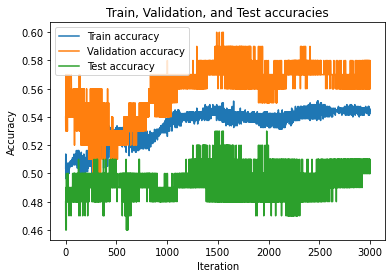

In [ ]:
plt.plot(node_class_accs['train'], label='Train accuracy')
plt.plot(node_class_accs['val'], label='Validation accuracy')
plt.plot(node_class_accs['test'], label='Test accuracy')
plt.title('Train, Validation, and Test accuracies')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
logits = node_class_model(node_class_graph, node_class_graph.ndata['feat'])
pred = logits.argmax(1)

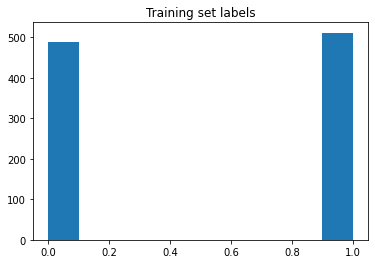

In [ ]:
label = node_class_graph.ndata['label']
plt.hist(label.cpu().numpy())
plt.title("Training set labels")
plt.show()

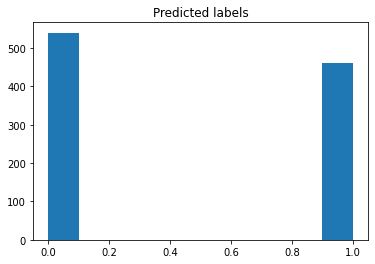

In [ ]:
plt.hist(pred.cpu().numpy())
plt.title("Predicted labels")
plt.show()

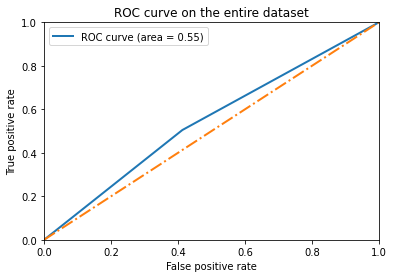

In [ ]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, _ = roc_curve(label.cpu().numpy(), pred.cpu().numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='-.')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve on the entire dataset')
plt.legend()
plt.show()

2. Graph classification:

In [ ]:
class GraphClassificationDataset(dgl.data.DGLDataset):
  """Process and convert the numpy training data into Graphs"""
  def __init__(self):
    super().__init__(name='graph_classification') 
    self.num_classes = 2
    self.dim_nfeats = 4
  
  def process(self):
    self.graphs = []
    self.labels = []
    num_examples = len(x_train_part1)
    num_train = int(num_examples * 0.8)
    num_val = int(num_examples * 0.1)
    train_mask = torch.zeros(num_examples, dtype=torch.bool)
    val_mask = torch.zeros(num_examples, dtype=torch.bool)
    test_mask = torch.zeros(num_examples, dtype=torch.bool)
    train_mask[:num_train] = True
    val_mask[num_train:num_train+num_val] = True
    test_mask[num_train+num_val:] = True
    self.train_mask = train_mask
    self.test_mask = test_mask
    self.val_mask = val_mask 

    for id in range(len(x_train_part1)):
      g = dgl.from_networkx(nx.generators.fast_gnp_random_graph(20, p=0.6))
      g.ndata['feat'] = torch.from_numpy(np.repeat(x_train_part1[id].reshape(1,4),20,0))
      g.ndata['label'] = torch.LongTensor([y_train_part1[id]]*20)
      self.graphs.append(g)
      self.labels.append(y_train_part1[id])
    
    self.labels = torch.LongTensor(self.labels)

  def __getitem__(self, idx):
    return self.graphs[idx], self.labels[idx]

  def __len__(self):
    return len(self.graphs)

graph_class_dataset = GraphClassificationDataset()
g_sample, label_sample = graph_class_dataset[0]
print(g_sample, label_sample)

Graph(num_nodes=20, num_edges=230,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}) tensor(1)


In [ ]:
num_examples = len(graph_class_dataset)
num_train = int(num_examples * 0.8)
num_val = int(num_examples * 0.1)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
val_sampler = SubsetRandomSampler(torch.arange(num_train, num_train+num_val))
test_sampler = SubsetRandomSampler(torch.arange(num_train+num_val, num_examples))

train_dataloader = GraphDataLoader(graph_class_dataset, sampler=train_sampler, batch_size=5, drop_last=False)
val_dataloader = GraphDataLoader(graph_class_dataset, sampler=val_sampler, batch_size=5, drop_last=False)
test_dataloader = GraphDataLoader(graph_class_dataset, sampler=test_sampler, batch_size=5, drop_last=False)

iter = iter(train_dataloader)
batch = next(iter)
print(batch)

[Graph(num_nodes=100, num_edges=1148,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), tensor([1, 1, 1, 1, 1])]


In [ ]:
batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())

graphs = dgl.unbatch(batched_graph)
print('The original graphs in the minibatch:')
print(graphs)

Number of nodes for each graph element in the batch: tensor([20, 20, 20, 20, 20])
Number of edges for each graph element in the batch: tensor([210, 222, 226, 252, 238])
The original graphs in the minibatch:
[Graph(num_nodes=20, num_edges=210,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=222,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=226,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=252,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=20, num_edges=238,
      ndata_schemes={'feat': Scheme(shape=(4,), dtype

In [ ]:
class GraphClassificationModel(torch.nn.Module):
  """Implement and forward pass the GNN"""
  def __init__(self, in_feats, num_classes):
    super(GraphClassificationModel, self).__init__()
    self.conv1 = GraphConv(in_feats, 16)
    self.conv2 = GraphConv(16, 32)
    self.conv3 = GraphConv(32, num_classes)

  def forward(self, g, in_feat):
    h = self.conv1(g, in_feat)
    h = torch.nn.functional.relu(h)
    h = self.conv2(g, h)
    h = torch.nn.functional.relu(h)
    h = self.conv3(g, h)
    g.ndata['h'] = h
    return dgl.mean_nodes(g, 'h')

graph_class_model = GraphClassificationModel(graph_class_dataset.dim_nfeats, graph_class_dataset.num_classes)

In [ ]:
def train(train_loader, val_loader, test_loader, model, num_epochs):
  """Training loop implementation"""
  losses = []
  accuracies = {'train':[], 'val': [], 'test': []}
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.9999))
  best_val_acc = 0.0
  best_test_acc = 0.0

  for e in range(num_epochs):
    train_acc_batch = []
    val_acc_batch = []
    test_acc_batch = []
    train_loss_batch = []
    for batched_graph, labels in train_loader:
      model.train()
      batched_graph, labels = batched_graph.to('cpu'), labels.to('cpu')
      logits = model(batched_graph, batched_graph.ndata['feat'].float())
      pred = logits.argmax(1)
      loss = torch.nn.functional.cross_entropy(logits, labels)
      train_loss_batch.append(loss)
      train_acc = (pred == labels).float().mean()
      train_acc_batch.append(train_acc)
      with torch.no_grad():  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuracies['train'].append(sum(train_acc_batch) / len(train_acc_batch))
    losses.append(sum(train_loss_batch) / len(train_loss_batch))

    model.eval()
    for batched_graph_val, labels_val in val_loader:
      batched_graph_val, labels_val = batched_graph_val.to('cpu'), labels_val.to('cpu')
      logits_val = model(batched_graph_val, batched_graph_val.ndata['feat'].float())
      pred_val = logits_val.argmax(1)
      val_acc = (pred_val == labels_val).float().mean()
      val_acc_batch.append(val_acc)
    accuracies['val'].append(sum(val_acc_batch) / len(val_acc_batch))

    for batched_graph_test, labels_test in test_loader:
      batched_graph_test, labels_test = batched_graph_test.to('cpu'), labels_test.to('cpu')
      logits_test = model(batched_graph_test, batched_graph_test.ndata['feat'].float())
      pred_test = logits_test.argmax(1)
      test_acc = (pred_test == labels_test).float().mean()
      test_acc_batch.append(test_acc)
    accuracies['test'].append(sum(test_acc_batch) / len(test_acc_batch))

    if best_val_acc < val_acc:
      best_val_acc = val_acc
      best_test_acc = test_acc

    if e % 5 == 0:
      print('In epoch {}, loss: {:.8f}, val acc: {:.8f} (best {:.8f}), test acc: {:.8f} (best {:.8f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
  
  return losses, accuracies

In [ ]:
graph_class_losses, graph_class_accs = train(train_dataloader, val_dataloader, test_dataloader, graph_class_model, 300)

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In epoch 0, loss: 2.27580500, val acc: 0.60000002 (best 0.60000002), test acc: 0.60000002 (best 0.60000002)
In epoch 5, loss: 0.71205413, val acc: 0.60000002 (best 0.60000002), test acc: 0.40000001 (best 0.60000002)
In epoch 10, loss: 0.70496625, val acc: 0.40000001 (best 0.80000001), test acc: 1.00000000 (best 0.60000002)
In epoch 15, loss: 0.68943453, val acc: 0.60000002 (best 0.80000001), test acc: 0.20000000 (best 0.60000002)
In epoch 20, loss: 0.71232653, val acc: 0.40000001 (best 0.80000001), test acc: 0.60000002 (best 0.60000002)
In epoch 25, loss: 0.68999290, val acc: 0.40000001 (best 0.80000001), test acc: 0.60000002 (best 0.60000002)
In epoch 30, loss: 0.70816422, val acc: 0.80000001 (best 0.80000001), test acc: 0.40000001 (best 0.60000002)
In epoch 35, loss: 0.75568050, val acc: 0.60000002 (best 0.80000001), test acc: 0.80000001 (best 0.60000002)
In epoch 40, loss: 0.68702447, val acc: 0.40000001 (best 1.00000000), test acc: 0.40000001 (best 0.60000002)
In epoch 45, loss: 0.

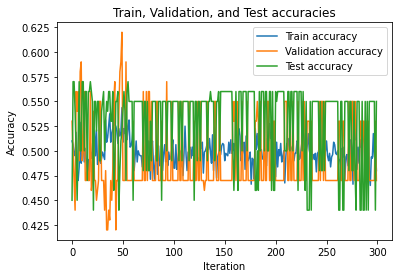

In [ ]:
plt.plot(graph_class_accs['train'], label='Train accuracy')
plt.plot(graph_class_accs['val'], label='Validation accuracy')
plt.plot(graph_class_accs['test'], label='Test accuracy')
plt.title('Train, Validation, and Test accuracies')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
all_pred_graph_class = []
for batched_graph_test, labels_test in test_dataloader:
    batched_graph_test = batched_graph_test.to('cpu')
    labels_test = labels_test.to('cpu')
    logits_test = graph_class_model(batched_graph_test, batched_graph_test.ndata['feat'].float())
    pred_test = logits_test.argmax(1)
    all_pred_graph_class = all_pred_graph_class + [*pred_test.cpu().numpy()]

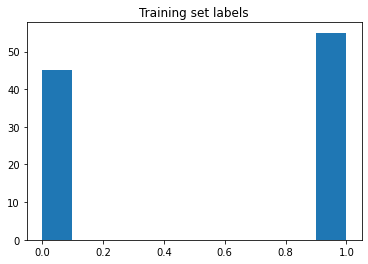

In [ ]:
label = graph_class_dataset.labels[graph_class_dataset.test_mask]
plt.hist(label.cpu().numpy())
plt.title("Training set labels")
plt.show()

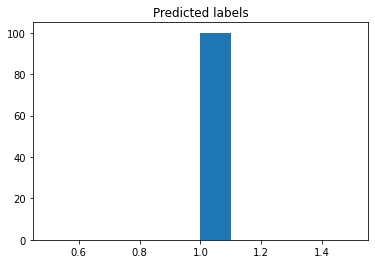

In [ ]:
plt.hist(all_pred_graph_class)
plt.title("Predicted labels")
plt.show()

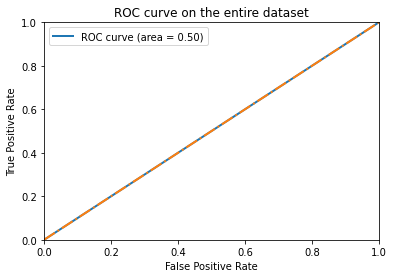

In [ ]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, _ = roc_curve(label.cpu().numpy(), all_pred_graph_class)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='-.')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on the entire dataset')
plt.legend()
plt.show()

The Graph classification training time was noticeably longer than the Node classification on the CPU.  The ROC shows that the graph classification is predicting the same output for all given inputs. 
Improving the training model by using more of the dataset and increasing the number of epochs might resolve these issues.

Dynamic graphs are also another possible approach where the structure of the graph can keep changing over time, and that includes both nodes and edges, which can be added, modified, deleted, and represented as an ordered list or a stream of time stamped events that change the structure of the graph.
